In [10]:
import pandas as pd
import qiime2 as q2
from biom import Table
import numpy as np
from qiime2.plugins.phylogeny.methods import filter_table
from skbio import OrdinationResults, TreeNode, DistanceMatrix
from qiime2.plugins.gemelli.actions import (ctf, rpca,
                                            phylogenetic_ctf_without_taxonomy,
                                            phylogenetic_rpca_without_taxonomy)
from qiime2.plugins.diversity.actions import (beta,
                                              beta_phylogenetic,
                                              pcoa)
from qiime2.plugins.feature_table.methods import rarefy, filter_samples, filter_features
from skbio.stats.distance import permanova
from qiime2.plugins.longitudinal.actions import first_distances

import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [11]:
all_table_stats = {}

# metaG

In [12]:
table_metag = q2.Artifact.load('../data/metaG/metaG-matched-table.qza')
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza')
tree_metag = q2.Artifact.load('../data/metaG/wol_tree.qza')
table_metag = filter_table(table_metag, tree_metag).filtered_table

bt = table_metag.view(Table)
n_features, n_samples = bt.shape
min_feature_frequency = 0
min_feature_count = 0
min_sample_count = 1e5
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)
def observation_filter(val, id_, md):
        return sum(val) > min_feature_count
bt = bt.filter(observation_filter, axis='observation')
bt = bt.filter(frequency_filter, axis='observation')
bt = bt.filter(bt.ids()[(bt.sum('sample') > min_sample_count)])

table_metag = q2.Artifact.import_data('FeatureTable[Frequency]', bt)
table_metag.view(Table)


5661 x 91 <class 'biom.table.Table'> with 177741 nonzero entries (34% dense)

In [13]:
table_metag.view(Table).sum('sample').min()

286001.0

In [14]:
rare_table_metag = rarefy(table_metag, 290000).rarefied_table


In [15]:
rpca_res = rpca(rare_table_metag)
#rpca_res = phylogenetic_rpca_without_taxonomy(rare_table_metag, tree_metag)
wunidist = beta_phylogenetic(rare_table_metag, tree_metag, 'weighted_unifrac').distance_matrix
unidist = beta_phylogenetic(rare_table_metag, tree_metag, 'unweighted_unifrac').distance_matrix
wunipcoa = pcoa(wunidist).pcoa
unipcoa = pcoa(unidist).pcoa


/Users/hazedil/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.15051160216799145 and the largest is 7.421941821234233.
  RuntimeWarning


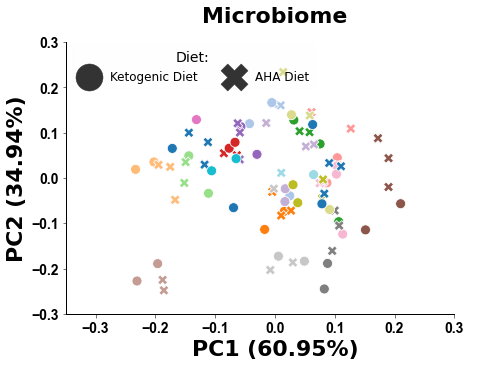

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

ordination_tmp = rpca_res.biplot
title_plot = 'Microbiome'
ordination_tmp_plot = pd.concat([ordination_tmp.view(OrdinationResults).samples[[0,1,2]], 
                                 metadata_metag.to_dataframe()], axis=1).dropna(subset=[1])

sns.scatterplot(x=0, y=1, hue='host_subject_id', data=ordination_tmp_plot,
                s=100, palette='tab20', style='diet_nocross', ax=ax)
ax.legend_.remove()
#sns.scatterplot(x=0, y=1, hue='diet', data=ordination_tmp_plot,
#                s=200, palette='Set1', ax=ax)


ax.set_xlabel('PC1 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[0] * 100),
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel('PC2 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[1] * 100),
          color='black',
          weight='bold',
          fontsize=22)
ax.set_title(title_plot,
          color='black',
          weight='bold',
             y=1.05,
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[-2:], labels[-2:],
                   loc=2, 
                         bbox_to_anchor=(0., 1.01),
                         prop={'size':12},
                         title="Diet:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=4.5)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
ax.spines['left'].set_bounds(-.3, .3)
ax.spines['bottom'].set_bounds(-.35, .3)
ax.set_ylim(-.3, .3)
ax.set_xlim(-.35, .35)

plt.savefig('../results/figures/microbiome_rpca.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

plt.show()

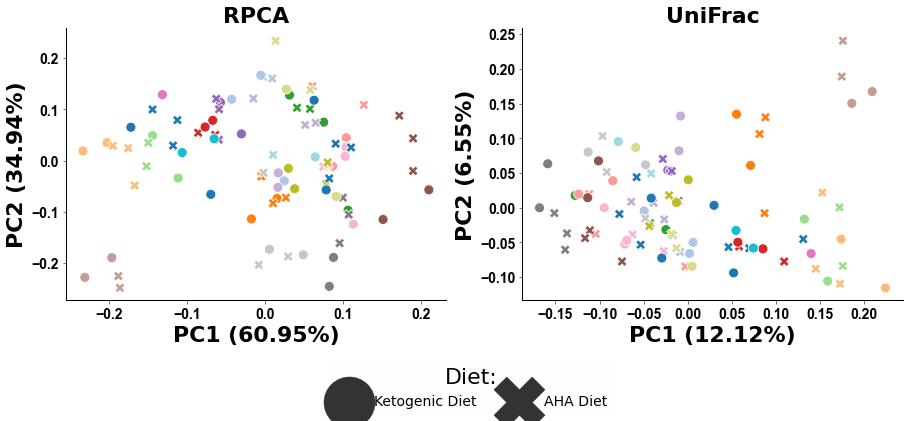

In [17]:
fig, axn = plt.subplots(1, 2, figsize=(15, 5))

for ax, title_plot, ordination_tmp in zip(axn,
                                          ['RPCA','UniFrac'],
                                          [rpca_res.biplot, unipcoa]):
    
    ordination_tmp_plot = pd.concat([ordination_tmp.view(OrdinationResults).samples[[0,1,2]], 
                                     metadata_metag.to_dataframe()], axis=1).dropna(subset=[1])
    
    sns.scatterplot(x=0, y=1, hue='host_subject_id', data=ordination_tmp_plot,
                    s=100, palette='tab20', style='diet_nocross', ax=ax)
    ax.legend_.remove()
    #sns.scatterplot(x=0, y=1, hue='diet', data=ordination_tmp_plot,
    #                s=200, palette='Set1', ax=ax)


    ax.set_xlabel('PC1 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[0] * 100),
              color='black',
              weight='bold',
              fontsize=22)
    ax.set_ylabel('PC2 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[1] * 100),
              color='black',
              weight='bold',
              fontsize=22)
    ax.set_title(title_plot,
              color='black',
              weight='bold',
              fontsize=22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')

    ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[-2:], labels[-2:],
                   loc=2, 
                         bbox_to_anchor=(-0.525, -0.2),
                         prop={'size':14},
                         title="Diet:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=8.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
"""axn[0].spines['left'].set_bounds(-.3, .2)
axn[0].spines['bottom'].set_bounds(-.3, .2)
axn[0].set_ylim(-.3, .2)
axn[0].set_xlim(-.35, .25)

axn[1].spines['left'].set_bounds(-.15, .25)
axn[1].spines['bottom'].set_bounds(-.2, .3)
axn[1].set_ylim(-.15, .25)
axn[1].set_xlim(-.25, .3)
"""

plt.show()



In [18]:

fd_tmp = first_distances(rpca_res.distance_matrix, metadata_metag,
                         'timepoint_encoded',
                         'host_subject_id',
                         baseline=1.0
                        ).first_distances
fd_tmp_df = pd.concat([fd_tmp.view(q2.Metadata).to_dataframe(), metadata_metag.to_dataframe()], axis=1)

fd_tmp_df = fd_tmp_df.dropna(subset=['Distance'])
#fd_tmp_df['Distance'] = fd_tmp_df['Distance'].fillna(1)
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}

fd_tmp_df['Period'] = [relabel_ticks[t_] for t_ in fd_tmp_df.timepoint_encoded]
fd_tmp_df['Sequence'] = fd_tmp_df['first_diet']
fd_tmp_df['Diet'] = fd_tmp_df['diet_nocross']
map_names = {k:i for i, k in enumerate(set(fd_tmp_df['host_subject_id']))}
fd_tmp_df['host_subject_id'] = [map_names[k] for k in fd_tmp_df['host_subject_id']]

"""md = smf.mixedlm("Distance ~ Sequence + Diet + Period + cog", fd_tmp_df, groups=fd_tmp_df["host_subject_id"])
mdf = md.fit()
print(mdf.summary())

mdf.summary().tables[1]"""

md = smf.ols("Distance ~ Diet + Period + Sequence + cog + host_subject_id",
                 fd_tmp_df, groups=fd_tmp_df)
mdf = md.fit()
print(mdf.summary())
all_table_stats[('RPCA','metagenomics')] = mdf.summary().tables[1]

mdf.summary().tables[1]


                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     2.962
Date:                Wed, 13 Jul 2022   Prob (F-statistic):            0.00993
Time:                        10:46:12   Log-Likelihood:                -46.434
No. Observations:                  67   AIC:                             108.9
Df Residuals:                      59   BIC:                             126.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.8101,0.243,3.340,0.001,0.325,1.296
Diet[T.Ketogenic Diet],0.2715,0.152,1.788,0.079,-0.032,0.575
Period[T.Post-diet 1],-0.2234,0.189,-1.180,0.243,-0.602,0.155
Period[T.Post-diet 2],0.3603,0.186,1.941,0.057,-0.011,0.732
Period[T.Pre-diet 2],-0.2320,0.181,-1.284,0.204,-0.594,0.130
cog[T.NC],-0.2664,0.138,-1.932,0.058,-0.542,0.009
Sequence,-0.0766,0.160,-0.478,0.635,-0.398,0.244
host_subject_id,0.0078,0.012,0.634,0.528,-0.017,0.032


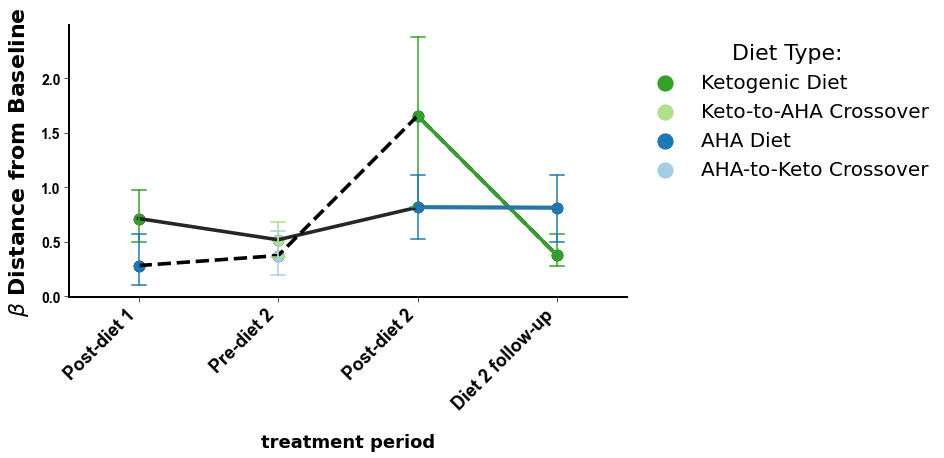

In [19]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1,1, figsize=(10,5))

pc_ = 'Distance'
sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
             data=fd_tmp_df, color='black', ci=95, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet',
             data=fd_tmp_df, palette=cmap_man, ci=95, ax=ax,
             errwidth=1.5, capsize=0.1)

"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('$\\beta$ Distance from Baseline',
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()


In [20]:
ctf_res_metag = ctf(table_metag, metadata_metag,
                    'host_subject_id',
                    'timepoint',
                    n_components=3,
                    min_feature_frequency=0,
                    min_feature_count=0)

orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

pd.DataFrame({t:tdf.cog.value_counts() for t, tdf in orddf.groupby(['timepoint_encoded','diet'])}).T


MCI  NC
1.0 AHA Diet                 1   5
    Ketogenic Diet           6   7
2.0 AHA Diet                 2   5
    Ketogenic Diet           6   6
3.0 AHA-to-Keto Crossover    2   5
    Keto-to-AHA Crossover    6   6
4.0 AHA Diet                 6   6
    Ketogenic Diet           2   4
5.0 AHA Diet                 6   5
    Ketogenic Diet           1   4

In [21]:
orddf['diet'].unique()

array(['Ketogenic Diet', 'Keto-to-AHA Crossover', 'AHA Diet',
       'AHA-to-Keto Crossover'], dtype=object)

In [22]:
orddf[['timepoint', 'diet']]

,timepoint,diet
#SampleID,,
13662.5555659,Pre 1,Ketogenic Diet
13662.5555660,Post 1,Ketogenic Diet
13662.5555661,FU 1 / Pre 2,Keto-to-AHA Crossover
13662.5555662,Post 2,AHA Diet
13662.5555663,FU 2,AHA Diet
...,...,...
13662.5556907,Pre 1,Ketogenic Diet
13662.5556908,Post 1,Ketogenic Diet
13662.5556909,FU 1 / Pre 2,Keto-to-AHA Crossover


In [23]:
orddf

,PC1,PC2,PC3,subject_id,timepoint,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,...,stool_position,taxon_id,title,tube_id,uom,visit_type,cog,diet,diet_nocross,timepoint_encoded
#SampleID,,,,,,,,,,,,,,,,,,,,,
13662.5555659,1.971418,-36.694295,28.333190,3AWFR000081,Pre 1,62.0,1263001.0,27.92,31102 Stool Box 1,2/4/15,...,1.0,408170.0,BEAM_U19,5555659.0,mg,PreA-Cog,MCI,Ketogenic Diet,Ketogenic Diet,1.0
13662.5555660,-6.287225,-36.387719,29.467705,3AWFR000081,Post 1,62.0,1263001.0,27.92,31102 Stool Box 1,3/24/15,...,2.0,408170.0,BEAM_U19,5555660.0,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet,2.0
13662.5555661,6.167159,-42.447992,43.622514,3AWFR000081,FU 1 / Pre 2,62.0,1263001.0,27.92,31102 Stool Box 1,5/5/15,...,3.0,408170.0,BEAM_U19,5555661.0,mg,PREB-COG,MCI,Keto-to-AHA Crossover,AHA Diet,3.0
13662.5555662,13.827740,-37.519685,30.160447,3AWFR000081,Post 2,62.0,1263001.0,27.92,31102 Stool Box 1,6/17/15,...,4.0,408170.0,BEAM_U19,5555662.0,mg,POSTB-COG,MCI,AHA Diet,AHA Diet,4.0
13662.5555663,-3.410111,-34.281280,25.222993,3AWFR000081,FU 2,62.0,1263001.0,27.92,31102 Stool Box 1,8/3/15,...,5.0,408170.0,BEAM_U19,5555663.0,mg,POSTB-FU,MCI,AHA Diet,AHA Diet,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13662.5556907,9.505115,-12.211890,11.740023,3RHHO001472,Pre 1,67.0,1263039.0,24.35,31102 Stool Box 2,10/5/16,...,17.0,408170.0,BEAM_U19,5556907.0,mg,PreA-Cog,MCI,Ketogenic Diet,Ketogenic Diet,1.0
13662.5556908,15.115899,-11.584407,12.725254,3RHHO001472,Post 1,67.0,1263039.0,24.35,31102 Stool Box 2,11/29/16,...,18.0,408170.0,BEAM_U19,5556908.0,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet,2.0
13662.5556909,6.654599,-23.988258,25.017521,3RHHO001472,FU 1 / Pre 2,67.0,1263039.0,24.35,31102 Stool Box 2,1/9/17,...,19.0,408170.0,BEAM_U19,5556909.0,mg,PREB-COG,MCI,Keto-to-AHA Crossover,AHA Diet,3.0


In [24]:
def diet_plotting_col(x):
    if x['timepoint_encoded']==3: 
        if x['diet']=='AHA-to-Keto Crossover':
            return 'AHA Washout'
        elif x['diet']=='Keto-to-AHA Crossover':
            return 'Keto Washout'
    elif x['timepoint_encoded']==5:
        if x['diet']=='AHA Diet':
            return 'AHA Washout'
        elif x['diet']=='Ketogenic Diet':
            return 'Keto Washout'
    return x['diet']   

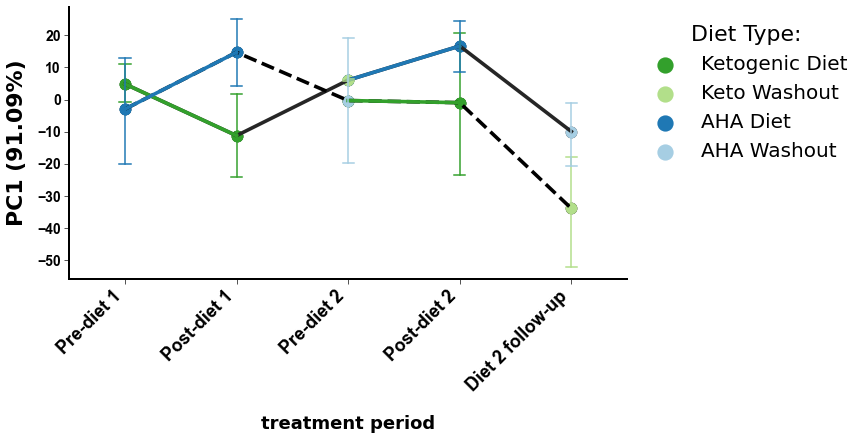

In [25]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA Washout':'#a6cee3',
             'Keto Washout':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}


orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))

pc_ = 'PC1'

sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
              data=orddf, color='black', ci=None, ax=ax,
              linestyles=['-','--'], errwidth=0)

# draw from point 1 to point 2 
# make nans at PC1 for everything except point1 and point2 
orddf_12 = orddf.copy()
orddf_12.loc[orddf_12['timepoint_encoded'] > 2, pc_] = np.nan
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_nocross',
             data=orddf_12, palette=cmap_man, ax=ax, ci=None)

# draw from point 3 to point 4 
# make nans at PC1 for everything except point3 and point4 
orddf_34 = orddf.copy()
orddf_34.loc[(orddf_34['timepoint_encoded'] < 3) | (orddf_34['timepoint_encoded'] == 5),pc_] = np.nan
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_nocross',
             data=orddf_34, palette=cmap_man, ax=ax, ci=None)

orddf['diet_plotting'] = orddf.apply(diet_plotting_col, axis=1)
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_plotting',
              data=orddf, ci=68, ax=ax, palette=cmap_man,
              errwidth=1.5, capsize=0.1, join=False)


"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC1 (%.2f%%)' % (ctf_res_metag.subject_biplot.view(OrdinationResults).proportion_explained[0] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[6:], labels[6:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="") 

plt.savefig('../results/figures/microbiome_ctf.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

plt.show()

In [28]:

#rpca_res.distance_matrix
#ctf_res_metag.distance_matrix
fd_tmp = first_distances(ctf_res_metag.distance_matrix, metadata_metag,
                         'timepoint_encoded',
                         'host_subject_id',
                         baseline=5.0
                        ).first_distances
fd_tmp_df = pd.concat([fd_tmp.view(q2.Metadata).to_dataframe(), metadata_metag.to_dataframe()], axis=1)

fd_tmp_df = fd_tmp_df.dropna(subset=['Distance'])
#fd_tmp_df['Distance'] = fd_tmp_df['Distance'].fillna(0)

fd_tmp_df['Period'] = [relabel_ticks[t_] for t_ in fd_tmp_df.timepoint_encoded]
fd_tmp_df['Sequence'] = fd_tmp_df['first_diet']
fd_tmp_df['Diet'] = fd_tmp_df['diet_nocross']
map_names = {k:i for i, k in enumerate(set(fd_tmp_df['host_subject_id']))}
fd_tmp_df['host_subject_id'] = [map_names[k] for k in fd_tmp_df['host_subject_id']]

md = smf.ols("Distance ~ Diet + cog + Period + Sequence + host_subject_id",
                 fd_tmp_df, groups=fd_tmp_df)
mdf = md.fit()
print(mdf.summary())
all_table_stats[('CTF','metagenomics')] = mdf.summary().tables[1]

mdf.summary().tables[1]




                            OLS Regression Results                            
Dep. Variable:               Distance   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     2.530
Date:                Wed, 13 Jul 2022   Prob (F-statistic):             0.0256
Time:                        10:48:55   Log-Likelihood:                -285.98
No. Observations:                  60   AIC:                             588.0
Df Residuals:                      52   BIC:                             604.7
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 50

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,50.7063,16.348,3.102,0.003,17.902,83.510
Diet[T.Ketogenic Diet],-28.8722,8.998,-3.209,0.002,-46.929,-10.816
cog[T.NC],3.4619,8.925,0.388,0.700,-14.448,21.372
Period[T.Post-diet 2],3.3846,12.048,0.281,0.780,-20.791,27.560
Period[T.Pre-diet 1],-7.2054,11.004,-0.655,0.515,-29.287,14.876
Period[T.Pre-diet 2],-4.2517,11.652,-0.365,0.717,-27.633,19.130
Sequence,2.2076,10.205,0.216,0.830,-18.271,22.686
host_subject_id,-1.0758,0.892,-1.206,0.233,-2.866,0.715


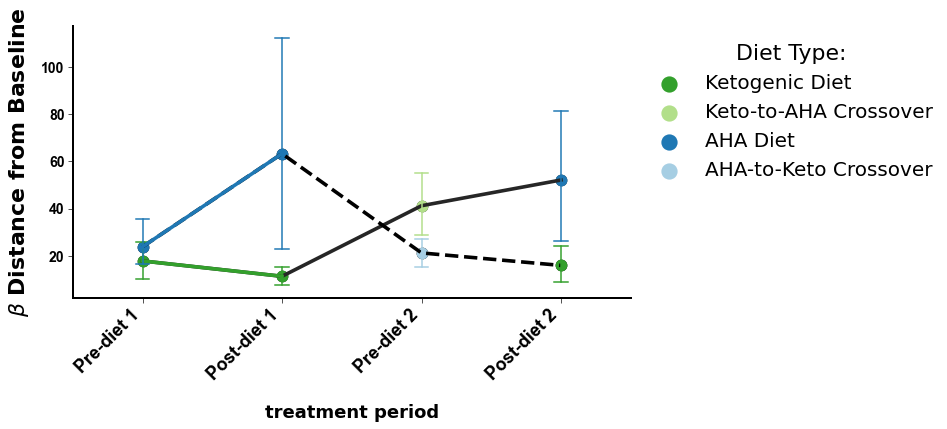

In [29]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
            'AHA-to-Keto Crossover':'#a6cee3',
            'Keto-to-AHA Crossover':'#b2df8a',
            'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1,1, figsize=(10,5))

pc_ = 'Distance'
sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
             data=fd_tmp_df, color='black', ci=95, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet',
             data=fd_tmp_df, palette=cmap_man, ci=95, ax=ax,
             errwidth=1.5, capsize=0.1)

"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('$\\beta$ Distance from Baseline',
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.savefig('../results/figures/microbiome_ctf_bdist.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

plt.show()


In [30]:
perm_res = {}

tmp_dst = ctf_res_metag.distance_matrix.view(DistanceMatrix).copy()

for t, tdf in orddf.groupby('timepoint_encoded'):
    t_tmp_dst = tmp_dst.copy()
    ids_keep = set(t_tmp_dst.ids) & set(tdf.index)
    t_tmp_dst = t_tmp_dst.filter(ids_keep)
    for rs in ['cog','diet','first_diet']:
        perm_tmp = permanova(t_tmp_dst, tdf.loc[ids_keep, rs])
        perm_res[(t, rs)] = (perm_tmp['test statistic'], perm_tmp['p-value'])

perm_res = pd.DataFrame(perm_res, ['test-stat','p-value']).T       
perm_res


test-stat  p-value
1.0 cog          0.591012    0.508
    diet         0.406312    0.622
    first_diet   0.406312    0.631
2.0 cog          0.027046    0.979
    diet         0.821205    0.484
    first_diet   0.821205    0.478
3.0 cog          2.496503    0.103
    diet         0.947324    0.411
    first_diet   0.947324    0.398
4.0 cog          1.479732    0.219
    diet         0.493922    0.638
    first_diet   0.493922    0.624
5.0 cog          1.001041    0.343
    diet         0.517394    0.544
    first_diet   0.517394    0.586

# food omics


In [58]:

table_metag = q2.Artifact.load('../data/metabolomics/matched-table-L5-metaG.qza')
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza')
table_metag.view(Table)



108 x 93 <class 'biom.table.Table'> with 4947 nonzero entries (49% dense)

In [59]:
table_metag.view(Table).sum('sample').min()

2434.0

In [60]:
rare_table_metag = rarefy(table_metag, 2400).rarefied_table

rpca_res = rpca(rare_table_metag, min_feature_frequency=10)


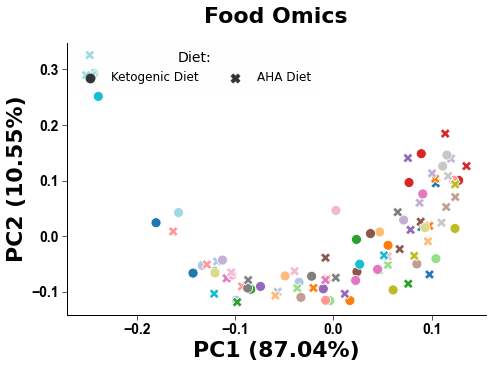

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

ordination_tmp = rpca_res.biplot
title_plot = 'Food Omics'
ordination_tmp_plot = pd.concat([ordination_tmp.view(OrdinationResults).samples[[0,1,2]], 
                                 metadata_metag.to_dataframe()], axis=1).dropna(subset=[1])

sns.scatterplot(x=0, y=1, hue='host_subject_id', data=ordination_tmp_plot,
                s=100, palette='tab20', style='diet_nocross', ax=ax)
ax.legend_.remove()
#sns.scatterplot(x=0, y=1, hue='diet', data=ordination_tmp_plot,
#                s=200, palette='Set1', ax=ax)


ax.set_xlabel('PC1 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[0] * 100),
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel('PC2 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[1] * 100),
          color='black',
          weight='bold',
          fontsize=22)
ax.set_title(title_plot,
          color='black',
          weight='bold',
             y=1.05,
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[-2:], labels[-2:],
                   loc=2, 
                         bbox_to_anchor=(0., 1.01),
                         prop={'size':12},
                         title="Diet:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=4.5)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#ax.spines['left'].set_bounds(-.3, .4)
#ax.spines['bottom'].set_bounds(-.25, .4)
#ax.set_ylim(-.3, .4)
#ax.set_xlim(-.25, .45)

plt.savefig('../results/figures/foodomics_rpca.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')


plt.show()

In [62]:
ctf_res_metag = ctf(table_metag, metadata_metag,
                    'host_subject_id', 'timepoint',
                    min_feature_frequency=5,
                    min_feature_count=0)
orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

pd.DataFrame({t:tdf.cog.value_counts() for t, tdf in orddf.groupby(['timepoint_encoded','diet'])}).T

MCI  NC
1.0 AHA Diet                 2   5
    Ketogenic Diet           6   6
2.0 AHA Diet                 2   5
    Ketogenic Diet           6   6
3.0 AHA-to-Keto Crossover    3   5
    Keto-to-AHA Crossover    6   6
4.0 AHA Diet                 6   6
    Ketogenic Diet           2   5
5.0 AHA Diet                 6   5
    Ketogenic Diet           1   4

ValueError: Could not interpret input 'Distance'

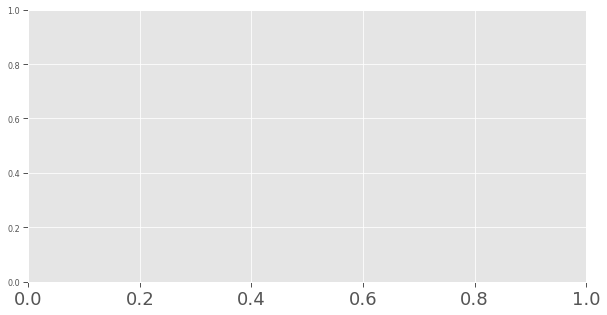

In [63]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
            'AHA Washout':'#a6cee3',
            'Keto Washout':'#b2df8a',
            'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))


sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
              data=orddf, color='black', ci=None, ax=ax,
              linestyles=['-','--'], errwidth=0)

# draw from point 1 to point 2 
# make nans at PC1 for everything except point1 and point2 
orddf_12 = orddf.copy()
orddf_12.loc[orddf_12['timepoint_encoded'] > 2, pc_] = np.nan
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_nocross',
             data=orddf_12, palette=cmap_man, ax=ax, ci=None)

# draw from point 3 to point 4 
# make nans at PC1 for everything except point3 and point4 
orddf_34 = orddf.copy()
orddf_34.loc[(orddf_34['timepoint_encoded'] < 3) | (orddf_34['timepoint_encoded'] == 5),pc_] = np.nan
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_nocross',
             data=orddf_34, palette=cmap_man, ax=ax, ci=None)

orddf['diet_plotting'] = orddf.apply(diet_plotting_col, axis=1)
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_plotting',
              data=orddf, ci=68, ax=ax, palette=cmap_man,
              errwidth=1.5, capsize=0.1, join=False)

"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC1 (%.2f%%)' % (ctf_res_metag.subject_biplot.view(OrdinationResults).proportion_explained[0] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
"""        
ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[6:], labels[6:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")
plt.savefig('../results/figures/foodomics_ctf.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
plt.show()



In [64]:

#rpca_res.distance_matrix
#ctf_res_metag.distance_matrix
fd_tmp = first_distances(ctf_res_metag.distance_matrix, metadata_metag,
                         'timepoint_encoded',
                         'host_subject_id',
                         baseline=5.0
                        ).first_distances
fd_tmp_df = pd.concat([fd_tmp.view(q2.Metadata).to_dataframe(), metadata_metag.to_dataframe()], axis=1)

fd_tmp_df = fd_tmp_df.dropna(subset=['Distance'])
#fd_tmp_df['Distance'] = fd_tmp_df['Distance'].fillna(0)

fd_tmp_df['Period'] = [relabel_ticks[t_] for t_ in fd_tmp_df.timepoint_encoded]
fd_tmp_df['Sequence'] = fd_tmp_df['first_diet']
fd_tmp_df['Diet'] = fd_tmp_df['diet_nocross']
md = smf.mixedlm("Distance ~ Sequence + Diet + Period + cog", fd_tmp_df, groups=fd_tmp_df["host_subject_id"])
mdf = md.fit()
print(mdf.summary())

mdf.summary().tables[1]

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Distance
No. Observations:      63         Method:                REML    
No. Groups:            16         Scale:                 0.5947  
Min. group size:       3          Log-Likelihood:        -82.7106
Max. group size:       4          Converged:             Yes     
Mean group size:       3.9                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept              -1.602    0.605 -2.645 0.008 -2.788 -0.415
Diet[T.Ketogenic Diet]  1.754    0.213  8.236 0.000  1.337  2.171
Period[T.Post-diet 2]  -0.412    0.293 -1.404 0.160 -0.986  0.163
Period[T.Pre-diet 1]   -1.229    0.273 -4.507 0.000 -1.763 -0.694
Period[T.Pre-diet 2]   -1.236    0.284 -4.351 0.000 -1.793 -0.679
cog[T.NC]              -

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.602,0.605,-2.645,0.008,-2.788,-0.415
Diet[T.Ketogenic Diet],1.754,0.213,8.236,0.000,1.337,2.171
Period[T.Post-diet 2],-0.412,0.293,-1.404,0.160,-0.986,0.163
Period[T.Pre-diet 1],-1.229,0.273,-4.507,0.000,-1.763,-0.694
Period[T.Pre-diet 2],-1.236,0.284,-4.351,0.000,-1.793,-0.679
cog[T.NC],-0.814,0.398,-2.047,0.041,-1.593,-0.034
Sequence,3.153,0.427,7.389,0.000,2.317,3.990
Group Var,0.400,0.318,,,,


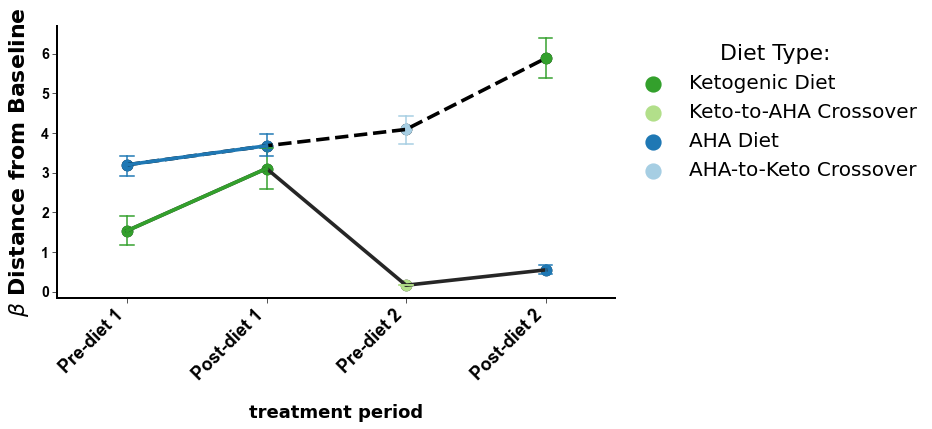

In [65]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1,1, figsize=(10,5))

pc_ = 'Distance'
sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
             data=fd_tmp_df, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet',
             data=fd_tmp_df, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)

"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('$\\beta$ Distance from Baseline',
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.savefig('../results/figures/foodomics_ctf_bdist.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

plt.show()

# metabolomics


In [50]:
table_metag = q2.Artifact.load('../data/metabolomics/matched-table-metaball-metaG.qza')
metadata_metag = q2.Metadata.load('../data/metaG/metaG-matched-metadata.qza')
table_metag.view(Table)


13954 x 93 <class 'biom.table.Table'> with 384145 nonzero entries (29% dense)

In [51]:
rpca_res = rpca(table_metag, min_feature_frequency=30)


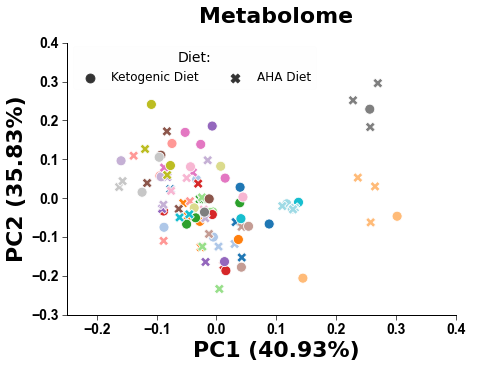

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5))

ordination_tmp = rpca_res.biplot
title_plot = 'Metabolome'
ordination_tmp_plot = pd.concat([ordination_tmp.view(OrdinationResults).samples[[0,1,2]], 
                                 metadata_metag.to_dataframe()], axis=1).dropna(subset=[1])

sns.scatterplot(x=0, y=1, hue='host_subject_id', data=ordination_tmp_plot,
                s=100, palette='tab20', style='diet_nocross', ax=ax)
ax.legend_.remove()
#sns.scatterplot(x=0, y=1, hue='diet', data=ordination_tmp_plot,
#                s=200, palette='Set1', ax=ax)


ax.set_xlabel('PC1 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[0] * 100),
          color='black',
          weight='bold',
          fontsize=22)
ax.set_ylabel('PC2 (%.2f%%)' % (ordination_tmp.view(OrdinationResults).proportion_explained[1] * 100),
          color='black',
          weight='bold',
          fontsize=22)
ax.set_title(title_plot,
          color='black',
          weight='bold',
             y=1.05,
          fontsize=22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[-2:], labels[-2:],
                   loc=2, 
                         bbox_to_anchor=(0., 1.01),
                         prop={'size':12},
                         title="Diet:",
                         fancybox=True, framealpha=.01,
                         ncol=2, markerscale=4.5)
legend.get_title().set_fontsize('14')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
ax.spines['left'].set_bounds(-.3, .4)
ax.spines['bottom'].set_bounds(-.25, .4)
ax.set_ylim(-.3, .4)
ax.set_xlim(-.25, .45)

plt.savefig('../results/figures/metabolome_rpca.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')


plt.show()

In [53]:
ctf_res_metag = ctf(rare_table_metag, metadata_metag, 'host_subject_id', 'timepoint',
                    min_feature_frequency=15, min_feature_count=0)
orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

pd.DataFrame({t:tdf.cog.value_counts() for t, tdf in orddf.groupby(['timepoint_encoded','diet'])}).T



MCI  NC
1.0 AHA Diet                 2   5
    Ketogenic Diet           6   6
2.0 AHA Diet                 2   5
    Ketogenic Diet           6   6
3.0 AHA-to-Keto Crossover    3   5
    Keto-to-AHA Crossover    6   6
4.0 AHA Diet                 6   6
    Ketogenic Diet           2   5
5.0 AHA Diet                 6   5
    Ketogenic Diet           1   4

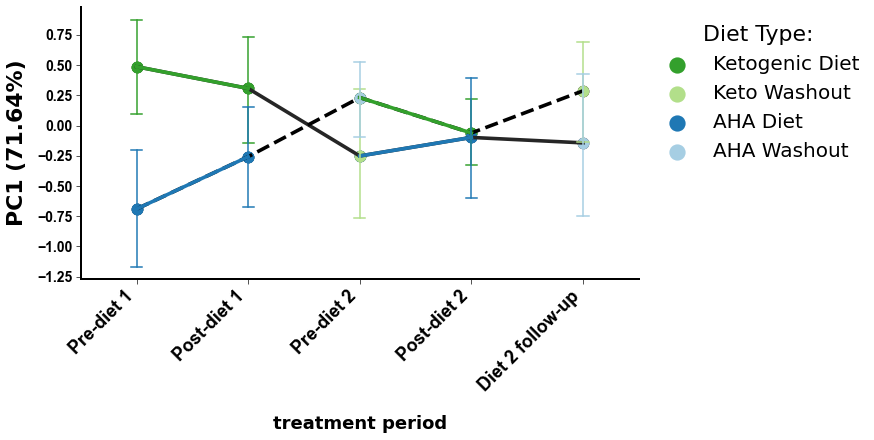

In [54]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
            'AHA Washout':'#a6cee3',
            'Keto Washout':'#b2df8a',
            'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))

pc_ = 'PC1'

sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)

# draw from point 1 to point 2 
# make nans at PC1 for everything except point1 and point2 
orddf_12 = orddf.copy()
orddf_12.loc[orddf_12['timepoint_encoded'] > 2, pc_] = np.nan
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_nocross',
             data=orddf_12, palette=cmap_man, ax=ax, ci=None)

# draw from point 3 to point 4 
# make nans at PC1 for everything except point3 and point4 
orddf_34 = orddf.copy()
orddf_34.loc[(orddf_34['timepoint_encoded'] < 3) | (orddf_34['timepoint_encoded'] == 5),pc_] = np.nan
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_nocross',
             data=orddf_34, palette=cmap_man, ax=ax, ci=None)

orddf['diet_plotting'] = orddf.apply(diet_plotting_col, axis=1)
sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet_plotting',
              data=orddf, ci=68, ax=ax, palette=cmap_man,
              errwidth=1.5, capsize=0.1, join=False)

"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC1 (%.2f%%)' % (ctf_res_metag.subject_biplot.view(OrdinationResults).proportion_explained[0] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
"""        
ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[6:], labels[6:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.savefig('../results/figures/metabolome_ctf.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

plt.show()


In [55]:
from qiime2.plugins.longitudinal.actions import first_distances

#rpca_res.distance_matrix
#ctf_res_metag.distance_matrix
fd_tmp = first_distances(ctf_res_metag.distance_matrix, metadata_metag,
                         'timepoint_encoded',
                         'host_subject_id',
                         baseline=5.0
                        ).first_distances
fd_tmp_df = pd.concat([fd_tmp.view(q2.Metadata).to_dataframe(), metadata_metag.to_dataframe()], axis=1)

fd_tmp_df = fd_tmp_df.dropna(subset=['Distance'])
#fd_tmp_df['Distance'] = fd_tmp_df['Distance'].fillna(0)

fd_tmp_df['Period'] = [relabel_ticks[t_] for t_ in fd_tmp_df.timepoint_encoded]
fd_tmp_df['Sequence'] = fd_tmp_df['first_diet']
fd_tmp_df['Diet'] = fd_tmp_df['diet_nocross']
md = smf.mixedlm("Distance ~ Sequence + Diet + Period + cog", fd_tmp_df, groups=fd_tmp_df["host_subject_id"])
mdf = md.fit()
print(mdf.summary())

mdf.summary().tables[1]

              Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Distance
No. Observations:      63         Method:                REML    
No. Groups:            16         Scale:                 0.0101  
Min. group size:       3          Log-Likelihood:        31.7217 
Max. group size:       4          Converged:             Yes     
Mean group size:       3.9                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.695    0.077  9.051 0.000  0.545  0.846
Diet[T.Ketogenic Diet]  0.351    0.028 12.595 0.000  0.296  0.405
Period[T.Post-diet 2]  -0.210    0.038 -5.484 0.000 -0.286 -0.135
Period[T.Pre-diet 1]    0.134    0.036  3.749 0.000  0.064  0.203
Period[T.Pre-diet 2]   -0.227    0.037 -6.124 0.000 -0.300 -0.155
cog[T.NC]              -

/Users/hazedil/opt/anaconda3/envs/qiime2-2020.6/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,0.695,0.077,9.051,0.000,0.545,0.846
Diet[T.Ketogenic Diet],0.351,0.028,12.595,0.000,0.296,0.405
Period[T.Post-diet 2],-0.210,0.038,-5.484,0.000,-0.286,-0.135
Period[T.Pre-diet 1],0.134,0.036,3.749,0.000,0.064,0.203
Period[T.Pre-diet 2],-0.227,0.037,-6.124,0.000,-0.300,-0.155
cog[T.NC],-0.011,0.050,-0.220,0.826,-0.109,0.087
Sequence,-0.153,0.054,-2.838,0.005,-0.259,-0.047
Group Var,0.006,0.040,,,,


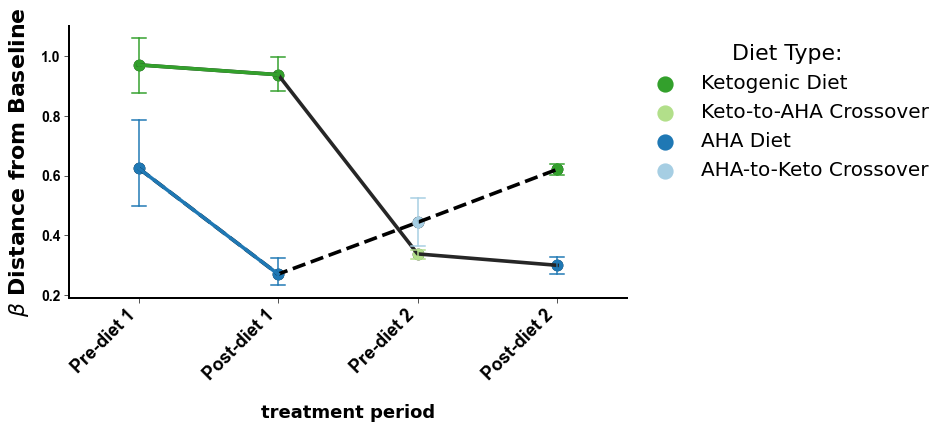

In [56]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

fig, ax = plt.subplots(1,1, figsize=(10,5))

pc_ = 'Distance'
sns.pointplot(y=pc_, x='timepoint_encoded', hue='first_diet',
             data=fd_tmp_df, color='black', ci=95, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y=pc_, x='timepoint_encoded', hue='diet',
             data=fd_tmp_df, palette=cmap_man, ci=95, ax=ax,
             errwidth=1.5, capsize=0.1)

"""Timepoint 1: pre-diet 1
Timepoint 2: post-diet 1
Timepoint 3: diet 1 follow-up/pre-diet 2
Timepoint 4: post-diet 2
Timepoint 5: diet 2 follow-up"""
relabel_ticks = {1:'Pre-diet 1', 2:'Post-diet 1', 3:'Pre-diet 2', 4:'Post-diet 2', 5:'Diet 2 follow-up'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('$\\beta$ Distance from Baseline',
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
"""ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-40, 20)
ax.set_ylim(-40, 20)"""
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.savefig('../results/figures/metabolome_bdist.pdf',dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')

plt.show()

In [57]:
mat = (table_metag.view(Table).matrix_data.toarray() / 1e4).astype(int)
bt_table_metag = Table(mat, table_metag.view(Table).ids('observation'), table_metag.view(Table).ids())
#bt_table_metag = bt_table_metag.filter(bt_table_metag.ids()[(bt_table_metag.sum('sample') / 1e11) > 0.3])
bt_table_metag = bt_table_metag.filter(bt_table_metag.ids()[(bt_table_metag.sum('sample') / 1e11) < 0.8])

mat = bt_table_metag.matrix_data.toarray() / 1e6
bt_table_metag = Table(mat.astype(int), bt_table_metag.ids('observation'), bt_table_metag.ids())

table_metag_div = q2.Artifact.import_data('FeatureTable[Frequency]', bt_table_metag)
table_metag_div
mat = (table_metag.view(Table).matrix_data.toarray()).astype(int)
bt_table_metag = pd.DataFrame(mat, table_metag.view(Table).ids('observation'), table_metag.view(Table).ids())

mat = (table_metag.view(Table).matrix_data.toarray() / 1e4).astype(int)
bt_table_metag = Table(mat, table_metag.view(Table).ids('observation'), table_metag.view(Table).ids())
table_metag_div = q2.Artifact.import_data('FeatureTable[Frequency]', bt_table_metag)
rare_table_metag = rarefy(table_metag_div, 100000).rarefied_table
rare_table_metag



<artifact: FeatureTable[Frequency] uuid: 7a668900-82c8-44f3-961f-7cfcfb3ed0aa>

# 16S

In [138]:
table_16s = q2.Artifact.load('../data/16S/16S-matched-table.qza')
metadata_16s = q2.Metadata.load('../data/16S/16S-matched-metadata.qza')
tree_16s = q2.Artifact.import_data('Phylogeny[Rooted]', '../data/16S/120736_insertion_tree.relabelled.tre')
table_16s = filter_table(table_16s, tree_16s).filtered_table
table_16s.view(Table)


7382 x 96 <class 'biom.table.Table'> with 26868 nonzero entries (3% dense)

In [285]:

for t, tdf in metadata_16s.to_dataframe().groupby('timepoint_encoded'): 
    
    t_table_16s = filter_samples(table_16s, metadata=q2.Metadata(tdf)).filtered_table
    t_rare_table_16s = rarefy(t_table_16s, 2500).rarefied_table
    rpca_res = rpca(t_table_16s)
    wunidist = beta_phylogenetic(t_rare_table_16s, tree_16s, 'weighted_unifrac').distance_matrix
    unidist = beta_phylogenetic(t_rare_table_16s, tree_16s, 'unweighted_unifrac').distance_matrix
    wunipcoa = pcoa(wunidist).pcoa
    unipcoa = pcoa(unidist).pcoa
    unifrac_by_time[t] = {}
    unifrac_by_time[t]['weighted'] = [wunidist, wunipcoa, tdf]
    unifrac_by_time[t]['unweighted'] = [unidist, unipcoa, tdf]
    unifrac_by_time[t]['rpca'] = [rpca_res.distance_matrix, rpca_res.biplot, tdf]


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00468949589265632 and the largest is 0.7267244974203827.
  RuntimeWarning
/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the resul

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


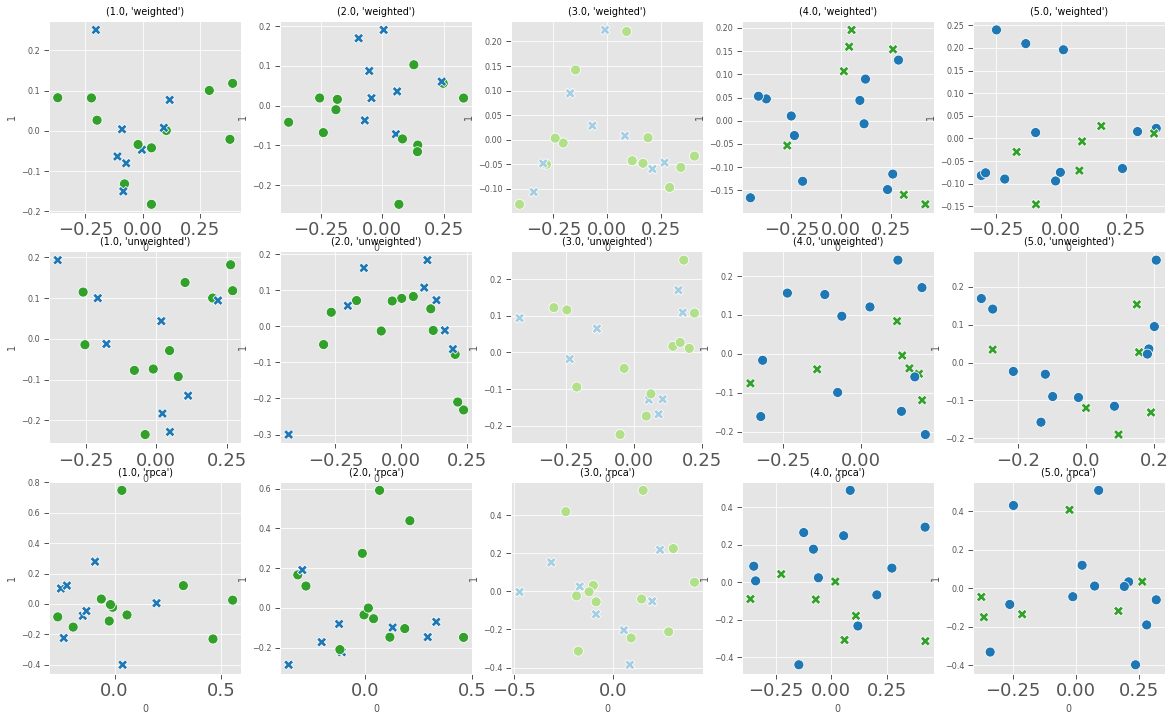

In [426]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}


fig, axn = plt.subplots(3, len(unifrac_by_time), figsize=(20, 12))

axn = axn.T.flatten()
ax_i = 0 

for time in unifrac_by_time.keys():
    for metric_type in ['weighted','unweighted', 'rpca']:
        
        ord_plot = pd.concat([unifrac_by_time[time][metric_type][1].view(OrdinationResults).samples[[0,1]],
                              unifrac_by_time[time][metric_type][2]], axis=1)
        ax = axn[ax_i]
        sns.scatterplot(x=0, y=1, hue='diet', style='first_diet', data=ord_plot, ax=ax, palette=cmap_man, s=100)
        ax.set_title((time, metric_type))
        ax.legend_.remove()
        ax_i += 1

plt.show()

/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


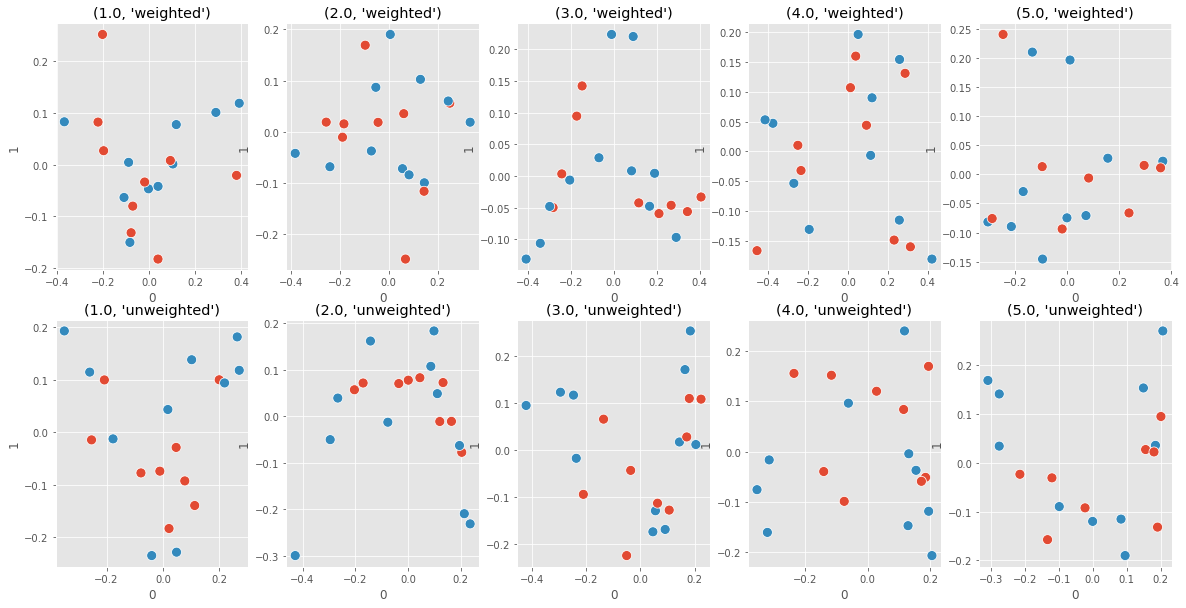

In [287]:

fig, axn = plt.subplots(2, len(unifrac_by_time), figsize=(20, 10))

axn = axn.T.flatten()
ax_i = 0 

for time in unifrac_by_time.keys():
    for metric_type in ['weighted','unweighted']:
        
        ord_plot = pd.concat([unifrac_by_time[time][metric_type][1].view(OrdinationResults).samples[[0,1]],
                              unifrac_by_time[time][metric_type][2]], axis=1)
        ax = axn[ax_i]
        sns.scatterplot(x=0, y=1, hue='cog', data=ord_plot, ax=ax, s=100)
        ax.set_title((time, metric_type))
        ax.legend_.remove()
        ax_i += 1

plt.show()

In [288]:
perm_res = {}

for time in unifrac_by_time.keys():
    
    for metric_type in ['weighted','unweighted', 'rpca']:
        
        tmp_dst = unifrac_by_time[time][metric_type][0].view(DistanceMatrix).copy()
        tdf = unifrac_by_time[time][metric_type][2].copy()
    
        t_tmp_dst = tmp_dst.copy()
        ids_keep = set(t_tmp_dst.ids) & set(tdf.index)
        t_tmp_dst = t_tmp_dst.filter(ids_keep)
        for rs in ['cog','diet','first_diet']:
            perm_tmp = permanova(t_tmp_dst, tdf.loc[ids_keep, rs])
            perm_res[(time, metric_type, rs)] = (perm_tmp['test statistic'], perm_tmp['p-value'])

perm_res = pd.DataFrame(perm_res, ['test-stat','p-value']).T       
perm_res

test-stat  p-value
1.0 weighted   cog          0.678589    0.622
               diet         0.637607    0.705
               first_diet   0.637607    0.716
    unweighted cog          0.941663    0.550
               diet         0.875219    0.713
               first_diet   0.875219    0.719
    rpca       cog          0.794358    0.500
               diet         1.598779    0.210
               first_diet   1.598779    0.219
2.0 weighted   cog          0.433203    0.912
               diet         1.284611    0.202
               first_diet   1.284611    0.242
    unweighted cog          0.797496    0.910
               diet         0.896515    0.640
               first_diet   0.896515    0.637
    rpca       cog          1.726768    0.183
               diet         1.837152    0.173
               first_diet   1.837152    0.158
3.0 weighted   cog          0.829074    0.419
               diet         0.346487    0.896
               first_diet   0.346487    0.899
    unweighted cog          0.865157    0.731
               diet         0.742558    0.972
               first_diet   0.742558    0.961
    rpca       cog          0.722257    0.484
               diet         0.652612    0.516
               first_diet   0.652612    0.548
4.0 weighted   cog          0.340233    0.926
               diet         1.617229    0.146
               first_diet   1.617229    0.163
    unweighted cog          0.769858    0.943
               diet         0.931330    0.539
               first_diet   0.931330    0.535
    rpca       cog          1.318946    0.300
               diet         1.801606    0.184
               first_diet   1.801606    0.138
5.0 weighted   cog          0.511573    0.770
               diet         0.803796    0.500
               first_diet   0.803796    0.498
    unweighted cog          0.885771    0.687
               diet         0.909429    0.619
               first_diet   0.909429    0.625
    rpca       cog          1.097756    0.374
               diet         0.618826    0.560
               first_diet   0.618826    0.555

In [302]:
ctf_res_16s_phylo = phylogenetic_ctf(table_16s, tree_16s, metadata_16s, 'host_subject_id', 'timepoint_encoded', min_feature_frequency=10)
ctf_res_16s= ctf(table_16s, metadata_16s, 'host_subject_id', 'timepoint_encoded', min_feature_frequency=10)



In [303]:
orddf = ctf_res_16s.state_subject_ordination.view(q2.Metadata).to_dataframe()

pd.DataFrame({t:tdf.cog.value_counts() for t, tdf in orddf.groupby(['timepoint_encoded','diet'])}).T

MCI  NC
1.0 AHA Diet                 3   5
    Ketogenic Diet           6   5
2.0 AHA Diet                 3   5
    Ketogenic Diet           6   6
3.0 AHA-to-Keto Crossover    3   5
    Keto-to-AHA Crossover    6   6
4.0 AHA Diet                 6   6
    Ketogenic Diet           3   4
5.0 AHA Diet                 6   6
    Ketogenic Diet           2   4

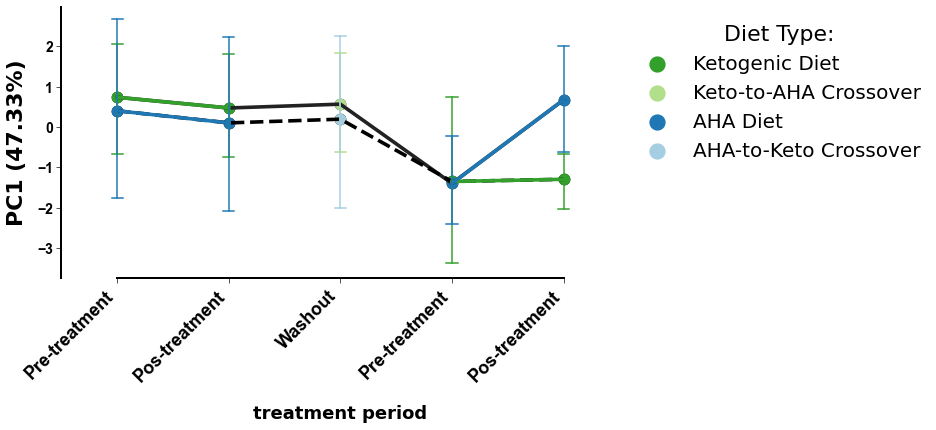

In [418]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_16s.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))


sns.pointplot(y='PC1', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='PC1', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-treatment', 2:'Pos-treatment', 3:'Washout', 4:'Pre-treatment', 5:'Pos-treatment'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC1 (%.2f%%)' % (ctf_res_16s.subject_biplot.view(OrdinationResults).proportion_explained[0] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(-40, 20)
#ax.set_ylim(-40, 20)
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()



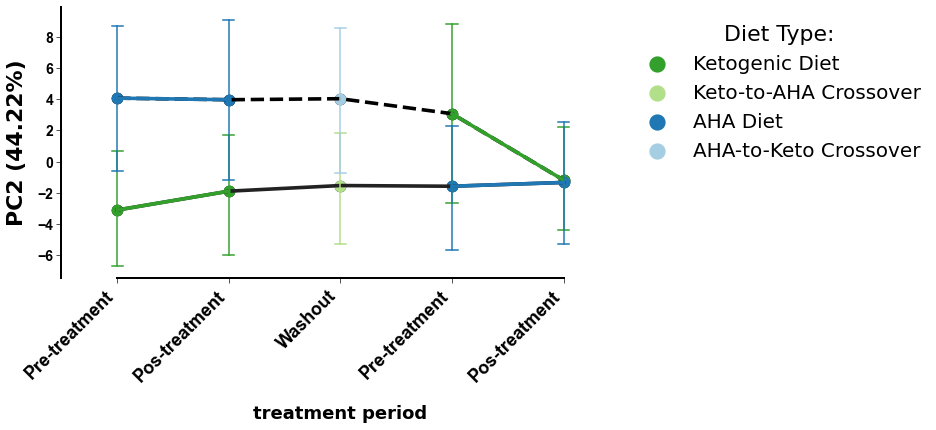

In [421]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_16s.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))


sns.pointplot(y='PC2', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='PC2', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-treatment', 2:'Pos-treatment', 3:'Washout', 4:'Pre-treatment', 5:'Pos-treatment'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC2 (%.2f%%)' % (ctf_res_16s.subject_biplot.view(OrdinationResults).proportion_explained[1] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
ax.spines['bottom'].set_bounds(0, 4)
#ax.spines['left'].set_bounds(-40, 20)
#ax.set_ylim(-40, 20)
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()


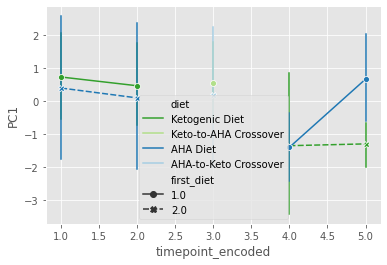

In [308]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_16s.state_subject_ordination.view(q2.Metadata).to_dataframe()

sns.lineplot(y='PC1', x='timepoint_encoded', hue='diet', style='first_diet', data=orddf, palette=cmap_man, markers=True, err_style="bars", ci=68)

plt.show()


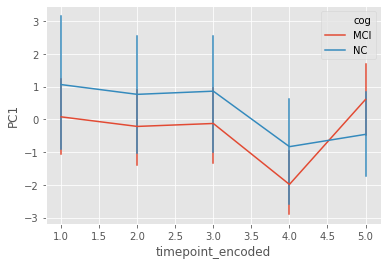

In [310]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_16s.state_subject_ordination.view(q2.Metadata).to_dataframe()

sns.lineplot(y='PC1', x='timepoint_encoded', hue='cog', data=orddf,markers=True, err_style="bars", ci=68)

plt.show()


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


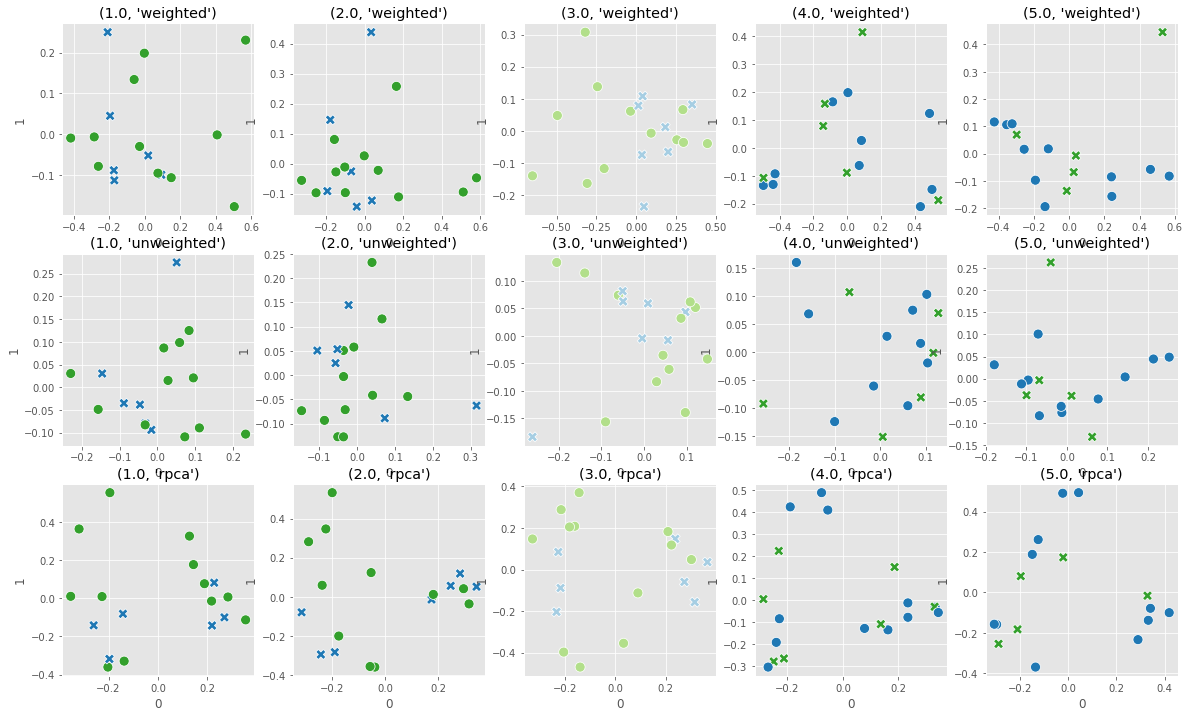

In [251]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}


fig, axn = plt.subplots(3, len(unifrac_by_time), figsize=(20, 12))

axn = axn.T.flatten()
ax_i = 0 

for time in unifrac_by_time.keys():
    for metric_type in ['weighted','unweighted', 'rpca']:
        
        ord_plot = pd.concat([unifrac_by_time[time][metric_type][1].view(OrdinationResults).samples[[0,1]],
                              unifrac_by_time[time][metric_type][2]], axis=1)
        ax = axn[ax_i]
        sns.scatterplot(x=0, y=1, hue='diet', style='first_diet', data=ord_plot, ax=ax, palette=cmap_man, s=100)
        ax.set_title((time, metric_type))
        ax.legend_.remove()
        ax_i += 1

plt.show()


/Users/cmartino/miniconda3/envs/qiime2-2021.2.songbird.mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


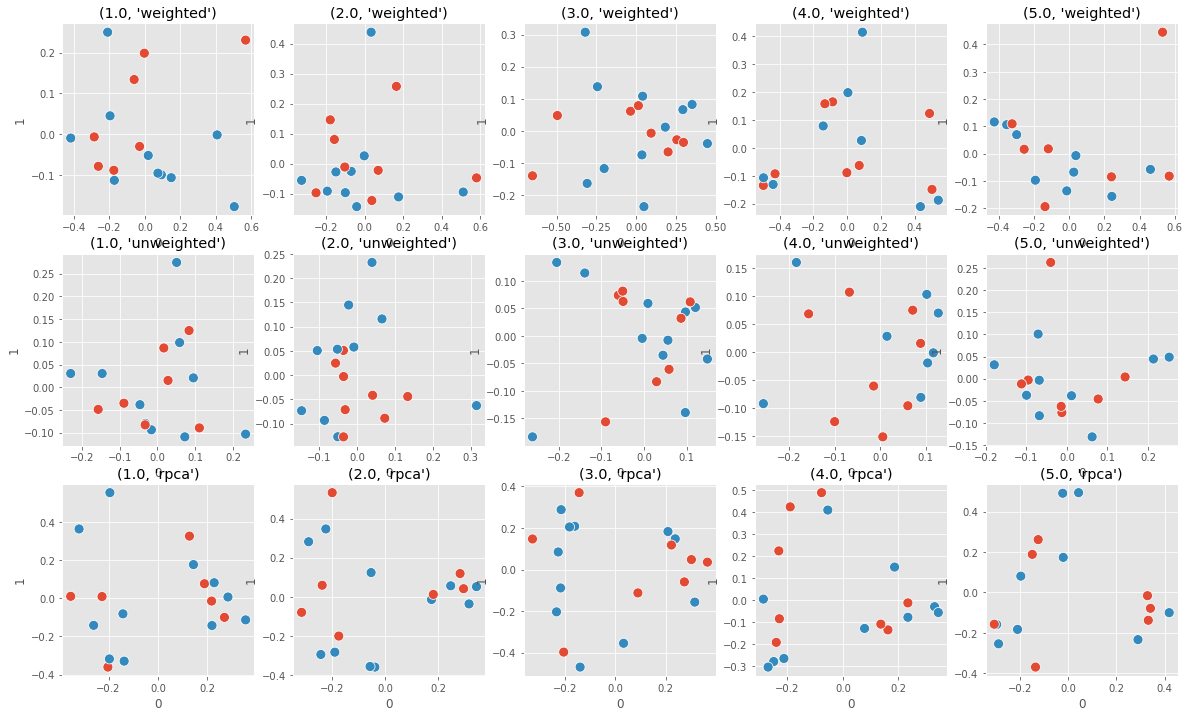

In [252]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}


fig, axn = plt.subplots(3, len(unifrac_by_time), figsize=(20, 12))

axn = axn.T.flatten()
ax_i = 0 

for time in unifrac_by_time.keys():
    for metric_type in ['weighted','unweighted', 'rpca']:
        
        ord_plot = pd.concat([unifrac_by_time[time][metric_type][1].view(OrdinationResults).samples[[0,1]],
                              unifrac_by_time[time][metric_type][2]], axis=1)
        ax = axn[ax_i]
        sns.scatterplot(x=0, y=1, hue='cog', data=ord_plot, ax=ax,s=100)
        ax.set_title((time, metric_type))
        ax.legend_.remove()
        ax_i += 1

plt.show()


In [279]:

perm_res = {}

for time in unifrac_by_time.keys():
    
    for metric_type in ['weighted','unweighted', 'rpca']:
        
        tmp_dst = unifrac_by_time[time][metric_type][0].view(DistanceMatrix).copy()
        tdf = unifrac_by_time[time][metric_type][2].copy()
    
        t_tmp_dst = tmp_dst.copy()
        ids_keep = set(t_tmp_dst.ids) & set(tdf.index)
        t_tmp_dst = t_tmp_dst.filter(ids_keep)
        for rs in ['cog','diet','first_diet']:
            perm_tmp = permanova(t_tmp_dst, tdf.loc[ids_keep, rs])
            perm_res[(time, metric_type, rs)] = (perm_tmp['test statistic'], perm_tmp['p-value'])

perm_res = pd.DataFrame(perm_res, ['test-stat','p-value']).T       
perm_res


test-stat  p-value
1.0 weighted   cog          0.583694    0.736
               diet         0.993512    0.381
               first_diet   0.993512    0.348
    unweighted cog          0.772466    0.940
               diet         0.999214    0.427
               first_diet   0.999214    0.421
    rpca       cog          0.108786    0.895
               diet         1.211472    0.328
               first_diet   1.211472    0.304
2.0 weighted   cog          0.643015    0.749
               diet         1.061004    0.357
               first_diet   1.061004    0.355
    unweighted cog          1.123474    0.189
               diet         0.972916    0.494
               first_diet   0.972916    0.498
    rpca       cog          0.454372    0.659
               diet         0.487568    0.609
               first_diet   0.487568    0.629
3.0 weighted   cog          0.327535    0.975
               diet         1.268453    0.236
               first_diet   1.268453    0.224
    unweighted cog          0.739777    0.969
               diet         0.908156    0.645
               first_diet   0.908156    0.638
    rpca       cog          0.464480    0.637
               diet         0.538057    0.598
               first_diet   0.538057    0.600
4.0 weighted   cog          0.439807    0.833
               diet         0.411965    0.881
               first_diet   0.411965    0.865
    unweighted cog          0.925599    0.569
               diet         0.842710    0.803
               first_diet   0.842710    0.800
    rpca       cog          0.636936    0.550
               diet         0.473472    0.654
               first_diet   0.473472    0.680
5.0 weighted   cog          0.669043    0.573
               diet         0.513699    0.768
               first_diet   0.513699    0.781
    unweighted cog          0.805528    0.892
               diet         0.799017    0.889
               first_diet   0.799017    0.888
    rpca       cog          0.332037    0.727
               diet         0.291852    0.751
               first_diet   0.291852    0.748

In [153]:
#ctf_res_metag_phylo = phylogenetic_ctf(table_metag, tree_metag, metadata_metag, 'host_subject_id', 'timepoint_encoded')
#ctf_res_metag = ctf(table_metag, metadata_metag, 'host_subject_id', 'timepoint_encoded')




In [197]:
#ctf_res_metag_phylo = phylogenetic_ctf(table_metag, tree_metag, metadata_metag,
#                                       'host_subject_id', 'timepoint_encoded',
#                                       min_feature_frequency=10)


MCI  NC
1.0 AHA Diet                 1   5
    Ketogenic Diet           6   6
2.0 AHA Diet                 2   5
    Ketogenic Diet           6   6
3.0 AHA-to-Keto Crossover    2   5
    Keto-to-AHA Crossover    6   6
4.0 AHA Diet                 6   6
    Ketogenic Diet           2   5
5.0 AHA Diet                 6   5
    Ketogenic Diet           1   4

In [476]:
orddf.groupby

,PC1,PC2,PC3,subject_id,timepoint_encoded,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,empo_3,env_biome,env_feature,env_material,env_package,first_diet,gender,geo_loc_name,host_age,host_age_units,host_body_habitat,host_body_mass_index,host_body_product,host_body_site,host_common_name,host_height,host_height_units,host_life_stage,host_scientific_name,host_taxid,host_weight,host_weight_units,latitude,longitude,memdx,physical_specimen_location,plasma,plasma_serum_box,plasma_serum_position,position,qiita_study_id,sample_type,scientific_name,serum,sex,specimen_quantity,status,stool,stool_box,stool_position,taxon_id,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross,period_decode,Period,Sequence,Diet
#SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13662.5555659,6.111107,-44.438412,37.227266,3AWFR000081,1.0,62.0,1263001.0,27.92,31102 Stool Box 1,2/4/15,2015-02-11,fecal sample Pre 1 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"22,23",1.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,1.0,408170.0,Pre 1,BEAM_U19,5555659.0,mg,PreA-Cog,MCI,Ketogenic Diet,Ketogenic Diet,Pre-treatment,Pre-treatment,1.0,Ketogenic Diet
13662.5555660,7.569715,-45.104316,30.052593,3AWFR000081,2.0,62.0,1263001.0,27.92,31102 Stool Box 1,3/24/15,2015-03-25,fecal sample Post 1 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"24,25",2.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,2.0,408170.0,Post 1,BEAM_U19,5555660.0,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet,Pos-treatment,Pos-treatment,1.0,Ketogenic Diet
13662.5555661,5.615704,-43.877990,45.183290,3AWFR000081,3.0,62.0,1263001.0,27.92,31102 Stool Box 1,5/5/15,2015-05-07,fecal sample FU 1 / Pre 2 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"26,27",3.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,3.0,408170.0,FU 1 / Pre 2,BEAM_U19,5555661.0,mg,PREB-COG,MCI,Keto-to-AHA Crossover,AHA Diet,Washout,Washout,1.0,AHA Diet
13662.5555662,6.245800,-44.237887,27.528429,3AWFR000081,4.0,62.0,1263001.0,27.92,31102 Stool Box 1,6/17/15,2015-06-22,fecal sample Post 2 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"28,29",4.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,4.0,408170.0,Post 2,BEAM_U19,5555662.0,mg,POSTB-COG,MCI,AHA Diet,AHA Diet,Pre-treatment,Pre-treatment,1.0,AHA Diet
13662.5555663,6.992957,-44.565958,41.727514,3AWFR000081,5.0,62.0,1263001.0,27.92,31102 Stool Box 1,8/3/15,2015-08-04,fecal sample FU 2 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"30,31",5.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,5.0,408170.0,FU 2,BEAM_U19,5555663.0,mg,POST

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-0.680,14.035,-0.048,0.961,-28.188,26.827
Diet[T.Ketogenic Diet],3.020,5.248,0.575,0.565,-7.265,13.305
Period[T.Pre-treatment],7.630,5.793,1.317,0.188,-3.723,18.984
Period[T.Washout],15.636,7.031,2.224,0.026,1.855,29.417
Sequence,-5.486,9.379,-0.585,0.559,-23.869,12.897
Group Var,272.997,6.165,,,,


test-stat  p-value
1.0 cog          0.229231    0.661
    diet         0.121232    0.818
    first_diet   0.121232    0.829
2.0 cog          0.747300    0.460
    diet         0.443180    0.648
    first_diet   0.443180    0.596
3.0 cog          0.387999    0.555
    diet         0.304880    0.601
    first_diet   0.304880    0.615
4.0 cog          0.680664    0.480
    diet         0.503961    0.559
    first_diet   0.503961    0.521
5.0 cog          0.568593    0.541
    diet         0.077818    0.931
    first_diet   0.077818    0.929

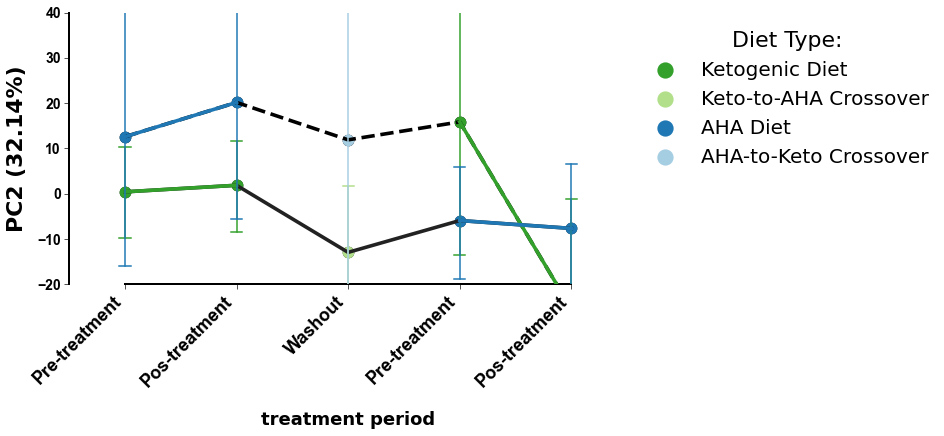

In [446]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))


sns.pointplot(y='PC2', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='PC2', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-treatment', 2:'Pos-treatment', 3:'Washout', 4:'Pre-treatment', 5:'Pos-treatment'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC2 (%.2f%%)' % (ctf_res_metag.subject_biplot.view(OrdinationResults).proportion_explained[1] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-20, 40)
ax.set_ylim(-20, 40)
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()



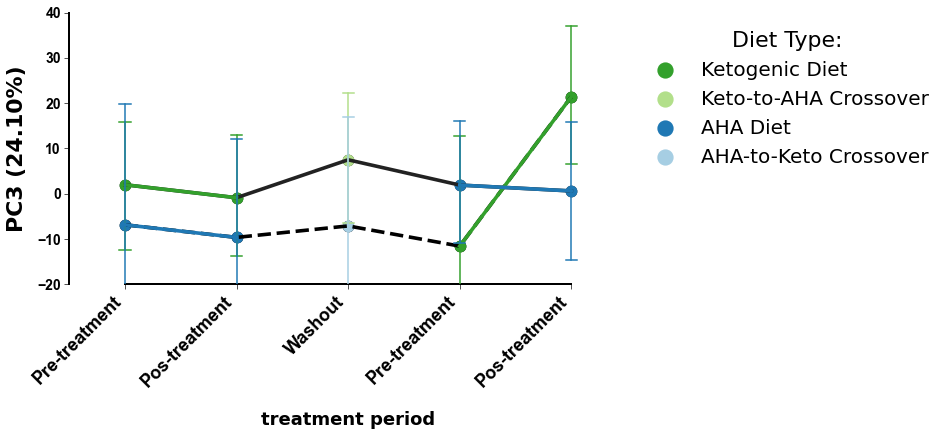

In [447]:
# set label font-sizes globally
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 2}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18 
plt.rcParams['ytick.labelsize'] = 8

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(10,5))


sns.pointplot(y='PC3', x='timepoint_encoded', hue='first_diet',
             data=orddf, color='black', ci=68, ax=ax,
              linestyles=['-','--'], errwidth=0)


sns.pointplot(y='PC3', x='timepoint_encoded', hue='diet',
             data=orddf, palette=cmap_man, ci=68, ax=ax,
             errwidth=1.5, capsize=0.1)


relabel_ticks = {1:'Pre-treatment', 2:'Pos-treatment', 3:'Washout', 4:'Pre-treatment', 5:'Pos-treatment'}
new_xtick = [relabel_ticks[float(x.get_text())] for x in ax.get_xticklabels()]
#ax.set_xticklabels(new_xtick)   
ax.set_xticklabels(new_xtick, rotation = 45, ha="right", fontsize=18, color='black', weight='bold')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(14)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(18)
    
ax.set_ylabel('PC3 (%.2f%%)' % (ctf_res_metag.subject_biplot.view(OrdinationResults).proportion_explained[2] * 100),
              color='black',
              weight='bold',
              labelpad=10,
              fontsize=22)
ax.set_xlabel('treatment period',
              color='black',
              weight='bold',
              labelpad=20,
              fontsize=18)

# fix backround
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
    ax.spines[axis].set_color('black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
        
ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(-20, 40)
ax.set_ylim(-20, 40)
            
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[2:], labels[2:],
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="Diet Type:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100, label="")

plt.show()


In [403]:
handles

[]

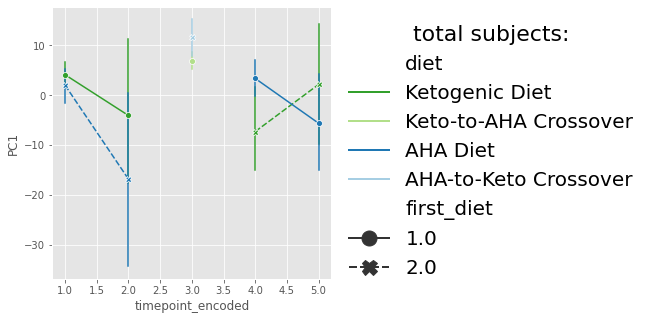

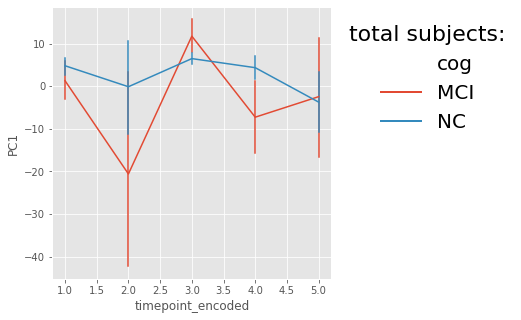

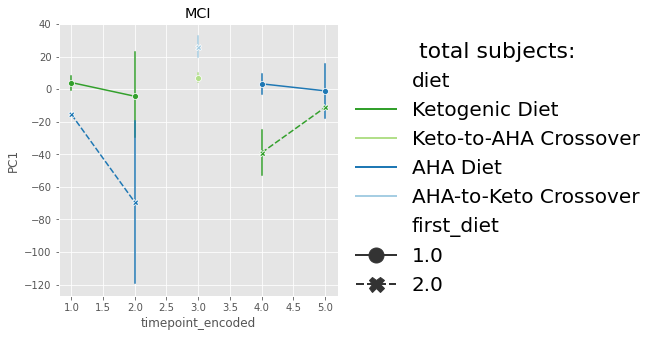

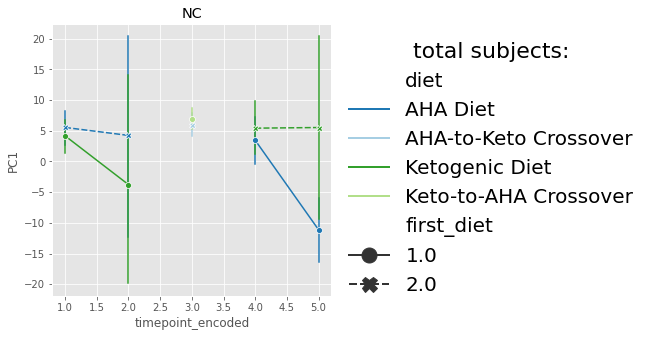

In [323]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

orddf = ctf_res_metag.state_subject_ordination.view(q2.Metadata).to_dataframe()

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.lineplot(y='PC1', x='timepoint_encoded', hue='diet', style='first_diet',
             data=orddf, palette=cmap_man, markers=True, err_style="bars", ci=68, ax=ax)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="total subjects:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=2.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

plt.show()

fig, ax = plt.subplots(1,1, figsize=(5,5))

sns.lineplot(y='PC1', x='timepoint_encoded', hue='cog',
             data=orddf, markers=True, err_style="bars", ci=68, ax=ax)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels,
                   loc=2, 
                         bbox_to_anchor=(1., 1.),
                         prop={'size':20},
                         title="total subjects:",
                         fancybox=False, framealpha=.0,
                         ncol=1, markerscale=2.5)
legend.get_title().set_fontsize('22')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)

plt.show()


for cog_t, cog_df in orddf.groupby('cog'):
    
    fig, ax = plt.subplots(1,1, figsize=(5,5))

    sns.lineplot(y='PC1', x='timepoint_encoded', hue='diet', style='first_diet',
                 data=cog_df, palette=cmap_man, markers=True, err_style="bars", ci=68, ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles, labels,
                       loc=2, 
                             bbox_to_anchor=(1., 1.),
                             prop={'size':20},
                             title="total subjects:",
                             fancybox=False, framealpha=.0,
                             ncol=1, markerscale=2.5)
    legend.get_title().set_fontsize('22')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(2.0)
    plt.title(cog_t)

    plt.show()


(0.8431145660979757, 0.441)

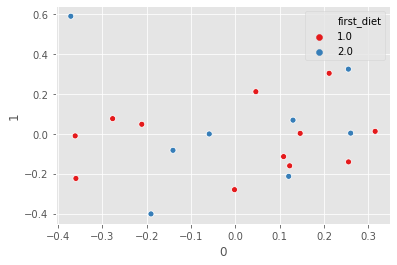

In [164]:
orddf = pd.concat([ctf_res_metag_phylo.subject_biplot.view(OrdinationResults).samples,
                   metadata_metag.to_dataframe().groupby('host_subject_id').agg({'first_diet':'first'})], axis=1)
orddf['first_diet'] = orddf['first_diet'].astype(str)
sns.scatterplot(x=0, y=1, hue='first_diet', palette='Set1', data=orddf)
plt.show()


613 x 8 <class 'biom.table.Table'> with 1096 nonzero entries (22% dense)

In [101]:
filter_features()

TypeError: filter_features() missing 1 required positional argument: 'table'

In [52]:
ctf_res_16s


Results (name = value)
--------------------------------------------------------------------------------------------------------------------
subject_biplot           = <artifact: PCoAResults % Properties('biplot') uuid: 34428664-71e7-4c7b-aba2-7ef58dbe067f>
state_biplot             = <artifact: PCoAResults % Properties('biplot') uuid: 02c7998b-82d3-4072-980a-95c6b8505a8d>
distance_matrix          = <artifact: DistanceMatrix uuid: 51ade685-f7c4-474c-ad35-4c0f81082cfe>
state_subject_ordination = <artifact: SampleData[SampleTrajectory] uuid: 11d02ee2-9fa1-4eb6-a2b8-902cbf2d7c8d>
state_feature_ordination = <artifact: FeatureData[FeatureTrajectory] uuid: 37c546f5-d081-458e-b222-63551e0b3dc5>

In [151]:
orddf = ctf_res_16s.state_subject_ordination.view(q2.Metadata).to_dataframe()
orddf.head(2)


,PC1,PC2,PC3,subject_id,timepoint_encoded,age,anonymized_name,bmi_pbl,box_name,cog_visit_date,collection_timestamp,description,elevation,empo_1,empo_2,empo_3,env_biome,env_feature,env_material,env_package,first_diet,gender,geo_loc_name,host_age,host_age_units,host_body_habitat,host_body_mass_index,host_body_product,host_body_site,host_common_name,host_height,host_height_units,host_life_stage,host_scientific_name,host_taxid,host_weight,host_weight_units,latitude,longitude,memdx,physical_specimen_location,plasma,plasma_serum_box,plasma_serum_position,position,qiita_study_id,sample_type,scientific_name,serum,sex,specimen_quantity,status,stool,stool_box,stool_position,taxon_id,timepoint,title,tube_id,uom,visit_type,cog,diet,diet_nocross
#SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
13662.5555659,-9.386436,5.142469,35.345203,3AWFR000081,1.0,62.0,1263001.0,27.92,31102 Stool Box 1,2/4/15,2015-02-11,fecal sample Pre 1 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"22,23",1.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,1.0,408170.0,Pre 1,BEAM_U19,5555659.0,mg,PreA-Cog,MCI,Ketogenic Diet,Ketogenic Diet
13662.5555660,-10.462298,5.312958,34.430405,3AWFR000081,2.0,62.0,1263001.0,27.92,31102 Stool Box 1,3/24/15,2015-03-25,fecal sample Post 1 3AWFR000081,300.0,Host-associated,Animal,Animal distal gut,urban biome,human-associated habitat,feces,human-gut,1.0,1.0,USA:North Carolina,62.0,years,UBERON:feces,27.92,UBERON:feces,UBERON:feces,human,not provided,cm,adult,Homo sapiens,9606.0,not provided,kg,36.1,-80.26,MCI-A,UCSDMI,1 x 0.5mL,2,"24,25",2.0,13662.0,feces,human gut metagenome,1 x 0.5mL,male,400.0,1.0,1 x 400mg,1.0,2.0,408170.0,Post 1,BEAM_U19,5555660.0,mg,POSTA-COG,MCI,Ketogenic Diet,Ketogenic Diet


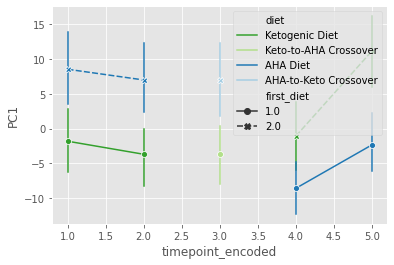

In [152]:

cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

sns.lineplot(y='PC1', x='timepoint_encoded', hue='diet', style='first_diet', data=orddf, palette=cmap_man, markers=True, err_style="bars", ci=68)

plt.show()



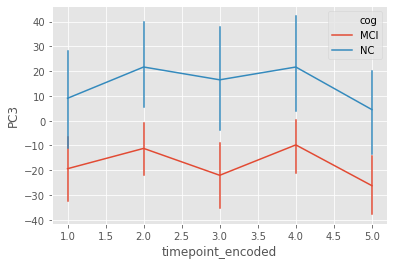

In [86]:
cmap_man = {'AHA Diet':'#1f78b4',
             'AHA-to-Keto Crossover':'#a6cee3',
             'Keto-to-AHA Crossover':'#b2df8a',
             'Ketogenic Diet':'#33a02c'}

sns.lineplot(y='PC3', x='timepoint_encoded', hue='cog',  data=orddf, markers=True, err_style="bars", ci=68)

plt.show()



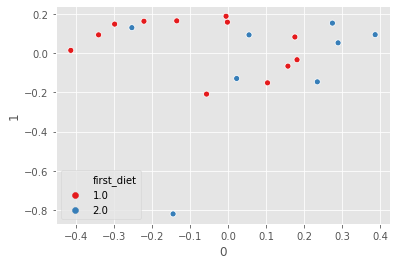

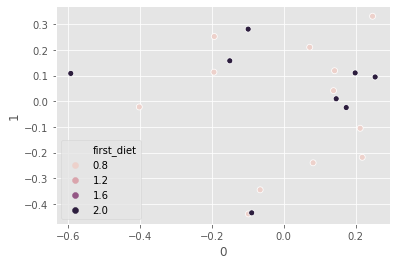

In [41]:
sns.scatterplot(x=0, y=1, hue='first_diet', data=orddf)
plt.show()